In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from data_preparation import veri_process_dir, veri_prepare_example_test_data, create_triplet
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from utils import Metric, Triplet_Dataset

In [1]:
import torch
from PIL import Image
from transformers import AutoProcessor, CLIPModel
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)



preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

FileNotFoundError: [Errno 2] No such file or directory: 'img1.jpg'

In [6]:
#Extract features from image1
image1 = Image.open('../../../data/VeRi/VeRi-UAV/image_train/0376_06_038_00053_3.jpg')
with torch.no_grad():
    inputs1 = processor(images=image1, return_tensors="pt").to(device)
    image_features1 = model.get_image_features(**inputs1)

#Extract features from image2
image2 = Image.open('../../../data/VeRi/VeRi-UAV/image_train/0434_05_031_00022_1.jpg')
with torch.no_grad():
    inputs2 = processor(images=image2, return_tensors="pt").to(device)
    image_features2 = model.get_image_features(**inputs2)

#Compute their cosine similarity and convert it into a score between 0 and 1
cos = nn.CosineSimilarity(dim=0)
sim = cos(image_features1[0],image_features2[0]).item()
sim = (sim+1)/2
print('Similarity:', sim)

Similarity: 0.9497950077056885


Processing image: ../../../data/VeRi/VeRi-UAV/image_train/0323_04_015_00025_2.jpg
similarity:  tensor(0.8555)
Processing image: ../../../data/VeRi/VeRi-UAV/image_train/0323_01_015_00017_6.jpg
similarity:  tensor(1.0000)
Processing image: ../../../data/VeRi/VeRi-UAV/image_train/0323_04_007_00007_2.jpg
similarity:  tensor(0.8234)
Processing image: ../../../data/VeRi/VeRi-UAV/image_train/0323_04_015_00027_3.jpg
similarity:  tensor(0.8370)
Processing image: ../../../data/VeRi/VeRi-UAV/image_train/0323_01_015_00006_6.jpg
similarity:  tensor(0.9171)
Processing image: ../../../data/VeRi/VeRi-UAV/image_train/0359_01_054_00006_10.jpg
similarity:  tensor(0.7974)
Processing image: ../../../data/VeRi/VeRi-UAV/image_train/0359_01_064_00026_16.jpg
similarity:  tensor(0.8304)
Processing image: ../../../data/VeRi/VeRi-UAV/image_train/0334_06_081_00013_13.jpg
similarity:  tensor(0.7808)
Processing image: ../../../data/VeRi/VeRi-UAV/image_train/0334_06_068_00005_7.jpg
similarity:  tensor(0.7520)
Process

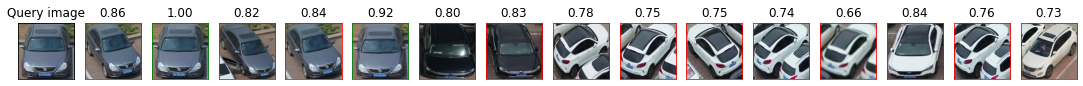

In [19]:
transform = T.Compose([
T.ToTensor(),
T.RandomHorizontalFlip(p=0.5),
T.Resize(224, interpolation=T.InterpolationMode.BILINEAR),
T.CenterCrop(224),
T.Normalize(mean=[0.5], std=[0.5]),
])

cos = torch.nn.CosineSimilarity(dim=0)
def imageSimilarity(image1, image2):
    with torch.no_grad():
       inputs1 = processor(images=image1, return_tensors="pt").to(device)
       image_features1 = model.get_image_features(**inputs1)

    #Extract features from image2

    with torch.no_grad():
       inputs2 = processor(images=image2, return_tensors="pt").to(device)
       image_features2 = model.get_image_features(**inputs2)
 
    result = cos(image_features1[0],image_features2[0])

    print("similarity: ", result)
    return result


from PIL import Image
import matplotlib.pyplot as plt
from data_preparation import veri_prepare_example_test_data

def similarityLoop_veri(queryImageTuple, datasetList, threshold):
    queryImagePath, label = queryImageTuple
    queryImage = Image.open(queryImagePath)
    fig, axes = plt.subplots(1, len(datasetList) + 1, figsize=(15, 5)) 
    createFig(axes[0], queryImage, "Query image")
    for idx, path in enumerate(datasetList):
        image_path = path[0]
        print("Processing image:", image_path)
        testImage = Image.open(image_path)
        score = imageSimilarity(queryImage, testImage)
        color = choose_color(threshold, score)
        createFig(axes[idx+1], testImage, f'{score:.2f}', color)
    plt.tight_layout()
#     plt.savefig('vehicle_comparison.png')
    
def choose_color(threshold, score):
    if score <= threshold:
        return 'red'
    return 'green'

    
def createFig(ax, image, title, color='black'):
    ax.imshow(image.resize((200, 200)))
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.set_title(title)
    for spine in ax.spines.values():
            spine.set_color(color)
    
test = veri_prepare_example_test_data('VeRi-UAV','../../../data/VeRi/VeRi-UAV/image_train/')
similarityLoop_veri(test[1], test, 0.85)